In [1]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter


from scripts.text_cleaning import clean_text, stop_words

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
df = pd.read_csv("../data/raw_analyst_ratings.csv")
news_df = df.copy()
# news_df = df.sample(n=10000, random_state=42)


In [3]:
print("Basic Understanding of the dataset")
print(news_df.info())
print(news_df.head(2))

Basic Understanding of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB
None
   Unnamed: 0                                    headline  \
0           0     Stocks That Hit 52-Week Highs On Friday   
1           1  Stocks That Hit 52-Week Highs On Wednesday   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   

                        date stock  
0  2020-06-05 

In [4]:
print("Basic Statistics for Textual Lengths in 'headline' Column")

news_df["headline_word_count"] = news_df["headline"].astype(str).str.split().str.len()
news_df["headline_char_count"] = news_df["headline"].astype(str).str.len()

colums_to_describe = ["headline_char_count", "headline_word_count"]

print(news_df[colums_to_describe].describe())


Basic Statistics for Textual Lengths in 'headline' Column
       headline_char_count  headline_word_count
count         1.407328e+06         1.407328e+06
mean          7.312051e+01         1.141671e+01
std           4.073531e+01         6.352997e+00
min           3.000000e+00         1.000000e+00
25%           4.700000e+01         7.000000e+00
50%           6.400000e+01         1.000000e+01
75%           8.700000e+01         1.300000e+01
max           5.120000e+02         7.700000e+01


In [5]:
print("Top 10 Most Active Publishers Based on Article Count:")

top_publishers = (
    news_df.groupby("publisher")
    .agg(article_count=("headline", "count"))
    .sort_values("article_count", ascending=False)
    .head(10)
    .reset_index()
)

print(top_publishers)

Top 10 Most Active Publishers Based on Article Count:
           publisher  article_count
0      Paul Quintaro         228373
1         Lisa Levin         186979
2  Benzinga Newsdesk         150484
3      Charles Gross          96732
4      Monica Gerson          82380
5       Eddie Staley          57254
6         Hal Lindon          49047
7      ETF Professor          28489
8         Juan Lopez          28438
9     Benzinga Staff          28114


Publication Trends over time
Plotting Daily Article Counts Over Time


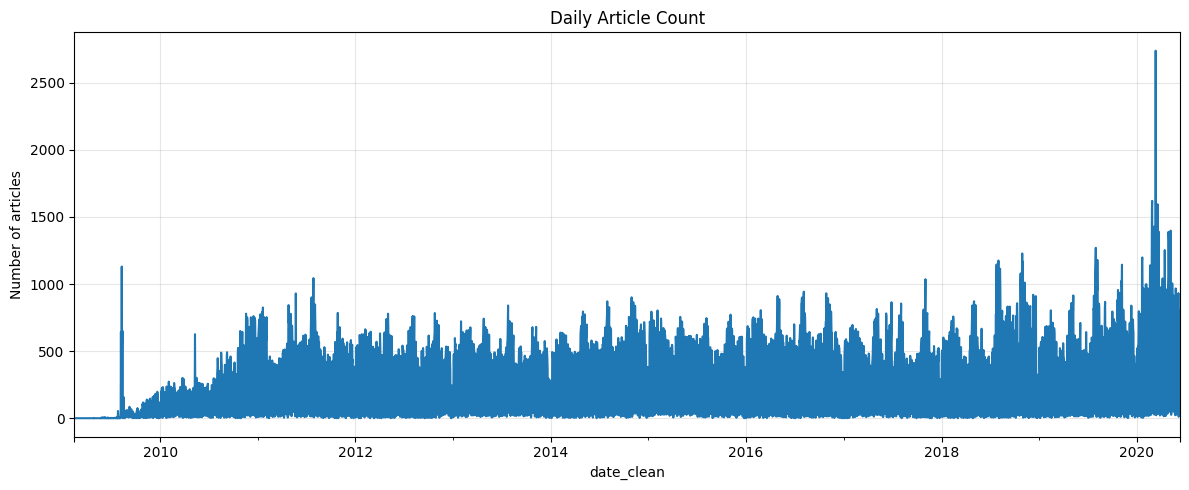

Plotting Monthly Article Counts Over Time


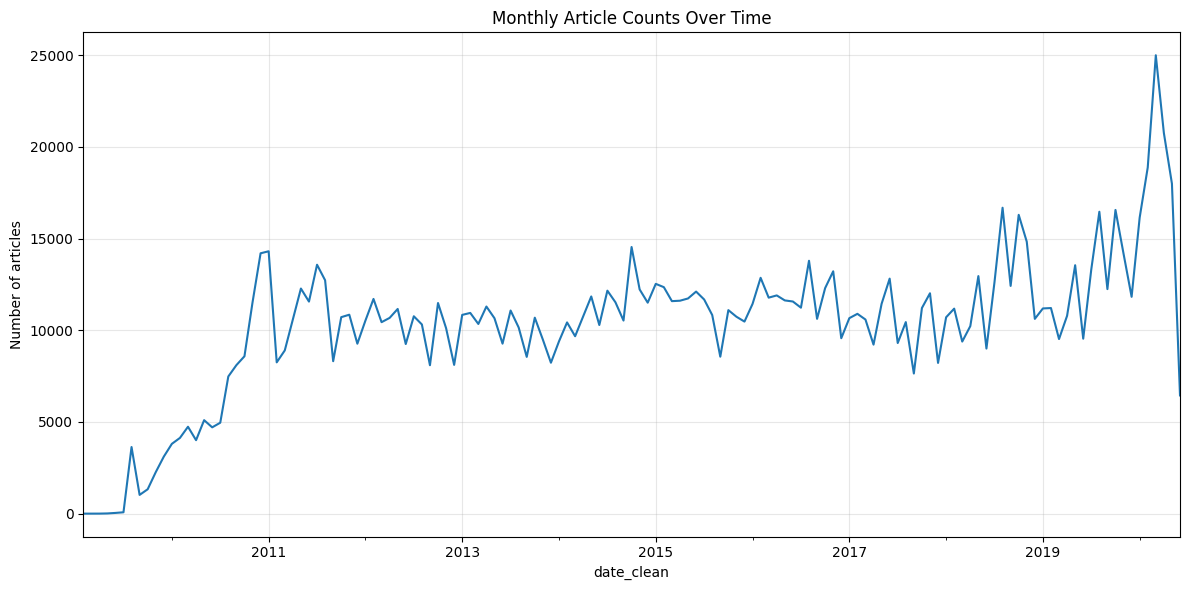

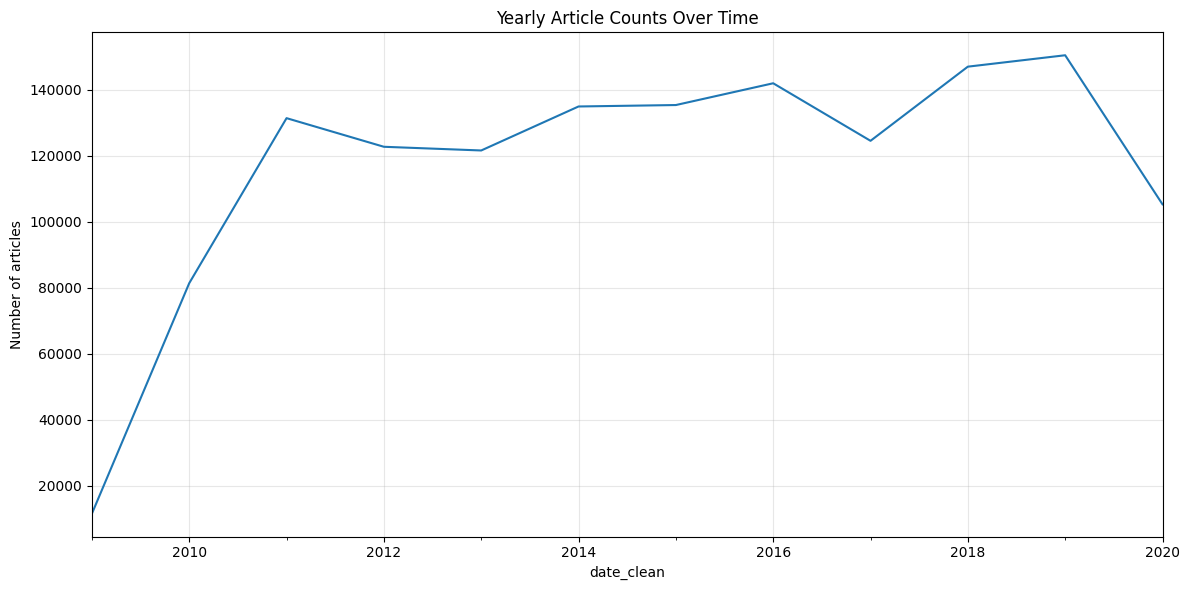

In [6]:
print("Publication Trends over time")

news_df["date_clean"] = pd.to_datetime(news_df["date"], format="mixed", utc=True, errors="coerce")
news_df["date_clean"] = news_df["date_clean"].dt.tz_localize(None)

news_df = news_df.set_index("date_clean").sort_index()

print("Plotting Daily Article Counts Over Time")
daily_counts = news_df.resample("D").size()
daily_counts.plot(figsize=(12, 5), title="Daily Article Count")
plt.ylabel("Number of articles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("Plotting Monthly Article Counts Over Time")
monthly_counts = news_df.resample("ME").size()
monthly_counts.plot(figsize=(12, 6), title="Monthly Article Counts Over Time")
plt.ylabel("Number of articles")
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


yearly_counts = news_df.resample("YE").size()
yearly_counts.plot(figsize=(12, 6), title="Yearly Article Counts Over Time")
plt.ylabel("Number of articles")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Text Analysis most common words
Most common words in headlines:


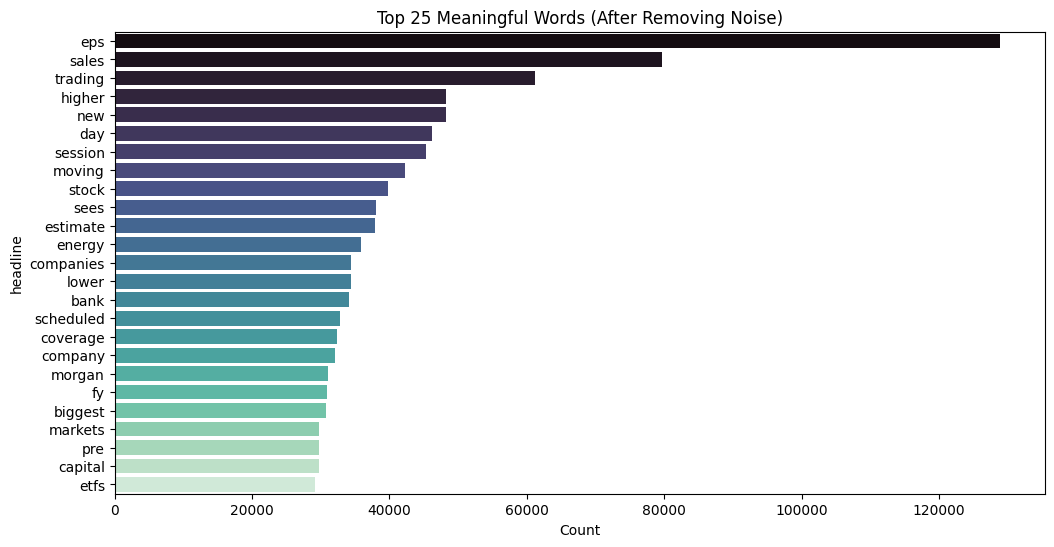

In [12]:
print("Text Analysis most common words")

headlines = news_df["headline"].dropna().apply(clean_text)

print("Most common words in headlines:")


words = headlines.str.split().explode()
words_clean = words[~words.isin(stop_words)]
words_clean = words_clean[words_clean.str.len() > 1]
real_words = words_clean.value_counts().head(25)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=real_words.values, y=real_words.index, palette="mako", hue=real_words.index
)
plt.title("Top 25 Meaningful Words (After Removing Noise)")
plt.xlabel("Count")
plt.show()

In [ ]:
print("Text Analysis most common phrases")


vectorizer = CountVectorizer(
    ngram_range=(2, 4),  
    min_df=20, 
    max_df=0.7,
)

X = vectorizer.fit_transform(headlines)
phrase_counts = pd.Series(X.sum(axis=0).A1, index=vectorizer.get_feature_names_out())
phrase_counts = phrase_counts.sort_values(ascending=False)

print("Top 10 Two-Word Phrases:")
print(phrase_counts.head(10))



Text Analysis most common phrases
